# Laboratory 5 - Graph analytics with Spark GraphFrames

## 1. Input Data

In [ ]:
airportsDF = spark.read.load("/data/students/bigdata_internet/lab5/airports.csv",\
                             format = "csv",
                             sep = ",",
                             header = True,
                             inferSchema = True)
airportsDF.createOrReplaceTempView('airportsTab')

In [2]:
airlinesDF = spark.read.load("/data/students/bigdata_internet/lab5/airlines.csv",\
                             format = "csv",
                             sep = ",",
                             header = True,
                             inferSchema = True)
airlinesDF.createOrReplaceTempView("airlinesTab")

In [ ]:
routesDF = spark.read.load("/data/students/bigdata_internet/lab5/routes.csv",\
                             format = "csv",
                             sep = ",",
                             header = True,
                             inferSchema = True)
routesDF.createOrReplaceTempView("routesTab")

## 2. Top airports and airlines

### 2.1) Which are the countries in the world with more than 200 airports? Reports these countries and their number of airports (in ascending order).

In [4]:
AirportsCountryDF = airportsDF.groupBy('country').agg({'country':'count'})\
.withColumnRenamed('count(country)','n_airports').where('n_airports >= 200')\
.sort('n_airports', ascending=True)

In [5]:
AirportsCountryDF.show(8)

[Stage 7:======================================================>(199 + 1) / 200]

+-------------+----------+
|      country|n_airports|
+-------------+----------+
|       France|       217|
|        China|       241|
|      Germany|       249|
|       Russia|       264|
|       Brazil|       264|
|    Australia|       334|
|       Canada|       430|
|United States|      1512|
+-------------+----------+



### 2.2) Which countries have the highest airports (in terms of altitude)? Reports the TOP-5 countries,their highest airport and its corresponding altitude in meters (in descending order)

In [6]:
CountryAirportDF = \
spark.sql('SELECT country, MAX(altitude) AS max_altitude\
        FROM airportsTab\
        GROUP BY country')
CountryAirportDF.createOrReplaceTempView('CountryAirportTab')

In [7]:
highestAirpotDF = \
spark.sql('SELECT at.country, at.name, (at.altitude/3.281) AS altitude\
        FROM CountryAirportTab AS cat, airportsTab AS at\
        WHERE at.country == cat.country AND altitude == cat.max_altitude\
        ORDER BY altitude DESC')

In [8]:
highestAirpotDF.show(5)

[Stage 10:>                                                         (0 + 1) / 1]

+---------+--------------------+-----------+
|  country|                name|   altitude|
+---------+--------------------+-----------+
|    China|Daocheng Yading A...|4410.850351|
|  Bolivia|El Alto Internati...|4070.405364|
|     Peru|Inca Manco Capac ...|3825.662908|
|    Nepal|  Syangboche Airport|3779.335568|
|Argentina|   La Quiaca Airport|3478.817434|
+---------+--------------------+-----------+
only showing top 5 rows



### 2.3) Which are the Top-10 routes in the world? Routes are identified by airport source and airport destination, independently on the airline. For each route in the Top-10, provide the source airport name and city, the destination airport name and city, and the number of routes (in descending order).

In [9]:
tmpRoutesDF =\
spark.sql('SELECT airport_source, airport_destination, count(*) as n_routes\
        FROM routesTab\
        GROUP BY airport_source, airport_destination')
tmpRoutesDF.createOrReplaceTempView('tmpRoutesTab')

In [10]:
topRoutesDF =\
spark.sql\
('SELECT atSrc.name, atSrc.city, atDst.name, atDst.city, tmp.n_routes\
FROM airportsTab AS atSrc, tmpRoutesTab AS tmp, airportsTab AS atDst \
WHERE atSrc.iata == tmp.airport_source AND atDst.iata == tmp.airport_destination\
GROUP BY atSrc.name, atSrc.city, atDst.name, atDst.city, tmp.n_routes\
ORDER BY tmp.n_routes DESC') 
                        

In [11]:
topRoutesDF.show(10)

[Stage 14:=====================================================>(198 + 2) / 200]

+--------------------+---------+--------------------+-----------+--------+
|                name|     city|                name|       city|n_routes|
+--------------------+---------+--------------------+-----------+--------+
|Chicago O'Hare In...|  Chicago|Hartsfield Jackso...|    Atlanta|      20|
|Hartsfield Jackso...|  Atlanta|Chicago O'Hare In...|    Chicago|      19|
|Chicago O'Hare In...|  Chicago|Louis Armstrong N...|New Orleans|      13|
|Phuket Internatio...|   Phuket|Suvarnabhumi Airport|    Bangkok|      13|
|Abu Dhabi Interna...|Abu Dhabi|Muscat Internatio...|     Muscat|      12|
|Guangzhou Baiyun ...|Guangzhou|Hangzhou Xiaoshan...|   Hangzhou|      12|
|Miami Internation...|    Miami|Hartsfield Jackso...|    Atlanta|      12|
|Hartsfield Jackso...|  Atlanta|Miami Internation...|      Miami|      12|
|Hong Kong Interna...|Hong Kong|Suvarnabhumi Airport|    Bangkok|      12|
|London Heathrow A...|   London|John F Kennedy In...|   New York|      12|
+--------------------+---

## 3. Create the graph of fligth connections

In [12]:
v = spark.sql('SELECT id, name\
                FROM airportsTab\
                WHERE iata != "\\\\N"')

In [13]:
e = \
spark.sql\
('SELECT rt.airport_source_id AS src, rt.airport_destination_id AS dst, at.iata\
FROM routesTab as rt, airlinesTab as at\
WHERE airport_source_id != "\\\\N" AND airport_destination_id != "\\\\N" AND at.airline_id == rt.airline_id')
e.createOrReplaceTempView('eTab')

### 3.1) How many rows did you filter out?

In [14]:
print("Number of rows filtered for airports.csv: ", airportsDF.count() - v.count())
print("Number of rows filtered for routes.csv: ", routesDF.count() - e.count())

Number of rows filtered for airports.csv:  1626
Number of rows filtered for routes.csv:  898


In [15]:
from graphframes import GraphFrame
v = v.withColumn("id", v.id.cast("string"))
v.createOrReplaceTempView('vTab')
e = e.withColumn("src", e.src.cast("string"))
e = e.withColumn("dst", e.dst.cast("string"))
g = GraphFrame(v,e)

## 4. Analyze and process the graph

### 4.1 Which are the airports with the highest ratio of incoming edges over outgoing ones

In [16]:
edgeIn = g.inDegrees
edgeIn.createOrReplaceTempView('edgeInTab')

In [17]:
edgeOut = g.outDegrees
edgeOut.createOrReplaceTempView('edgeOutTab')

In [18]:
edgeDF = \
spark.sql
('SELECT vTab.name, in.id, in.inDegree, out.outDegree, (in.inDegree/out.outDegree) AS ratio\
                    FROM edgeInTab as in, edgeOutTab as out, vTab\
                    WHERE in.id == out.id AND vTab.id == in.id\
                    ORDER BY ratio DESC')

In [19]:
edgeDF.show(5)

[Stage 30:=====================================================>(199 + 1) / 200]

+--------------------+----+--------+---------+-----+
|                name|  id|inDegree|outDegree|ratio|
+--------------------+----+--------+---------+-----+
|Portland Internat...|3862|      18|        2|  9.0|
|       Banak Airport| 653|       3|        1|  3.0|
|    Suavanao Airport|5416|       3|        1|  3.0|
|      Yeager Airport|4285|      15|        6|  2.5|
|   Longreach Airport|6289|       5|        2|  2.5|
+--------------------+----+--------+---------+-----+
only showing top 5 rows



### 4.2.1 From how many airports can you reach the city of "Bari" taking exactly 1 flight?

In [20]:
motifs = g.find('()-[e]->(b)')

In [21]:
onlyBariDst = motifs.filter((motifs.b.id == 1501))
print("Number of flights: ", onlyBariDst.count())

Number of flights:  50


### 4.2.2 How many airports can you reach from the city of "Bari" taking exactly 1 flight?

In [22]:
motifs = g.find('(a)-[e]->()')

In [23]:
onlyBariSrc = motifs.filter((motifs.a.id == 1501))
print("Number of flights: ", onlyBariSrc.count())

Number of flights:  50


### 4.2.3 Any comments in the numbers? Can you justify the result (consider the node's degrees...)?

In [24]:
edgeDF.where('id == 1501').show()

[Stage 45:====================================>                (138 + 62) / 200]

+--------------------+----+--------+---------+-----+
|                name|  id|inDegree|outDegree|ratio|
+--------------------+----+--------+---------+-----+
|Bari Karol Wojtył...|1501|      50|       50|  1.0|
+--------------------+----+--------+---------+-----+



Because the incoming and outgoing degrees are equal to the number of departures from Bari and arrivals to Bari without stopovers, it means that from Bari took place only direct flights.

### 4.3 How many airports can you reach from the city of "Bari" taking exactly 2 flight?

In [25]:
motifs = g.find('(a)-[e1]->(b); (b)-[e2]->(c)')
onlyBariSrc = motifs.filter((motifs.a.id == 1501))
onlyBariSrc.count()

7261

## Given the "Los Angeles International Airport" and the airport in the city of "Catania", compute:

In [26]:
airportsDF.select('id', 'name', 'city')\
.where('name == "Los Angeles International Airport" OR city == "Catania"')\
.show()

+----+--------------------+-----------+
|  id|                name|       city|
+----+--------------------+-----------+
|1509|Catania-Fontanaro...|    Catania|
|3484|Los Angeles Inter...|Los Angeles|
+----+--------------------+-----------+



### 4.4.1 From how many airports in the world you can reach "Los Angeles International Airport" using less hops than to reach the city of Catania

In [ ]:
id_LA = "3484"
id_Cat = "1509"
landmarks = [id_Cat, id_LA]
hopsDF = g.shortestPaths(landmarks=landmarks)

In [28]:
distDF = hopsDF.select(f'distances.{id_Cat}',f'distances.{id_LA}' )\
.withColumnRenamed(id_Cat, 'd_cat').filter('d_cat IS NOT null')\
.withColumnRenamed(id_LA, 'd_LA').filter('d_LA IS NOT null')
distDF.count()

3072

In [29]:
distDF.filter('d_LA < d_cat').count()

1734

### 4.4.2 From how many airports in the world you can reach the city of Catania using less hops than to reach "Los Angeles International Airport"

In [30]:
distDF.filter('d_LA > d_cat').count()

136

### 4.4.3 From how many airports in the world you can reach with the same number of hops Catania and "Los Angeles International Airport"

In [41]:
distDF.filter('d_LA == d_cat').count()

1202

### 4.5 How many connected components of at least two airports are there in the graph? Report the number of connected components and their sizes.

In [ ]:
sc.setCheckpointDir("LAB05/tmp_ckpts")

In [ ]:
g1 = g.dropIsolatedVertices()
ConnComp = g1.connectedComponents()

In [43]:
ConnComp.createOrReplaceTempView("connCompTab")

In [44]:
twoAirportCompDF = \
spark.sql\
('SELECT conncomptab.component, count(conncomptab.component) AS countComp\
FROM connCompTab\
GROUP BY conncomptab.component\
HAVING countComp >= 2\
ORDER BY countComp DESC\
')

In [45]:
print("Components with at least two airports: ", twoAirportCompDF.count())

Components with at least two airports:  7


### 4.6 Consider only the subgraph of the flights that are performed by two different airlines (identified by the ICAO), each involving at least 6 cities. Choose two airlines and plot the subgraph of these flights. Report the name of the cities (of the airports) in the graph.

In [46]:
connect = g.find('(a)-[e1]->(b);(c)-[e2]->(d)')
DfGraph = connect.filter(connect.a.id == connect.c.id)\
.filter(connect.b.id == connect.d.id)\
.filter(connect.e1.iata != connect.e2.iata)
DfGraph.createOrReplaceTempView("conn")

In [47]:
dfEnd = \
spark.sql\
('SELECT e1.iata, e2.iata, count(distinct(e2.src))+count(distinct(e2.dst)) AS Number_of_city\
FROM conn\
GROUP BY e1.iata, e2.iata\
HAVING count(distinct(e2.src))+count(distinct(e2.dst)) > 6')
#taking only the airline with more than 6 city connected

In [48]:
connect1 = g.find('(a)-[e1]->(b);(c)-[e2]->(d)')
DfUlt = connect1.filter(connect1.a.id == connect1.c.id)\
.filter(connect1.b.id == connect1.d.id).filter(connect1.e1.iata == "OS")\
.filter(connect1.e2.iata == "LH") # 14 city

In [49]:
from graphviz import Digraph
def vizGraph(edge_list,node_list):
    Gplot=Digraph()
    edges=edge_list.collect()
    nodes=node_list.collect()
    for row in edges:
        Gplot.edge(row['src'],row['dst'],label=row['iata'])
    for row in nodes:
        Gplot.node(row['id'],label=row['name'])
    return Gplot

In [51]:
Gplot = vizGraph(DfUlt["e1.src","e1.dst","e1.iata"],\
                 DfUlt["a.id","a.name","b.id","b.name"])

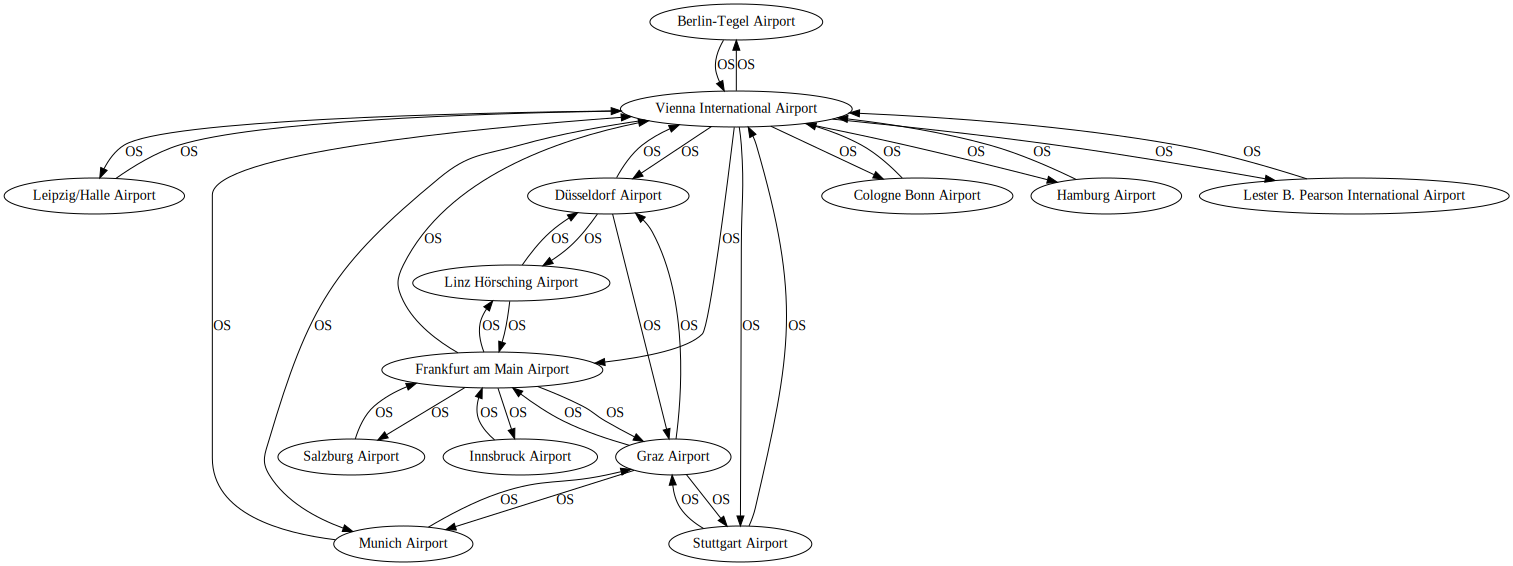

In [52]:
Gplot